<a href="https://it-omscholing.nl/locaties/hogeschool-rotterdam/">
<div>
<a><img src='../../pics/banner.PNG'/></a>
</div>
<div>
<a href=''><img src='../../pics/miw.PNG'/></a>
</div>
</a>

# Practicum Convolution Neural Nets (CNN) Deel 1

**Doel: Toepassen Convolutional Neural Networks**

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision.io import ImageReadMode
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import torch

<h3>Globale variabelen</h3>

In [2]:
forestDirectory = '../../pics/2750/Forest'
industrialDirectory = '../../pics/2750/Industrial'

### Context

<p>
Dit practicum bestaat uit twee onderdelen
<ol>
    <li>Het toepassen van een convolutie en pooling filter</li>
    <li>Het bouwen en trainen van een eenvoudig convolutional neural net dat een industrieterrein van een bos kan onderscheiden. Voor beide oefeningen gebruiken we de EuroSAT_RGB dataset</li>
</p>

<img src='../../pics/eurosat_cnn.png' length=65% width=65%>

<h3>Data Collection</h3>
<p>
We gebruiken Images uit de <a href="https://github.com/phelber/EuroSAT">EuroSat dataset</a> die gemaakt zijn met de Sentinel-2 sateliet. Elke image is een 64x64 pixels foto van Europees aardoppervlak op een hoogte van 10 meter. De images zijn te categoriseren in Highway, Industrial, Pasture, PermanentCrop, Residential, River en SeaLake.
</p>
<img src=../../pics/eurosat_overview_small.jpg length=40% width=40%>
<p>
Download <a href="http://madm.dfki.de/files/sentinel/EuroSAT.zip">EuroSAT.zip</a> en kopieer daaruit de directory 2750 naar opdrachten/practica/pics.      
<strong>Voeg het pad naar de directory 2750 toe aan .gitignore zodat je de plaatjes niet naar je remote git repository pusht</strong>
</p>    

## Opdrachten

### Opdracht 1: Afbeelding inladen

PyTorch Vision maakt het inladen van afbeeldingen gemakkelijk via [read_image van Torch Vison](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image).

<p>
Bekijk de documentatie van de <i>PyTorch io module</i> en laad de afbeelding 'Industrial_1.jpg' in variable <u>industrial</u> als een 1-dimensionale Torch Tensor met float waarden.
</p>

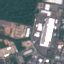

In [3]:
# eerst even kijken hoe het plaatje er uit ziet
from IPython.display import Image 
pil_img = Image(filename='../../pics/2750/Industrial/Industrial_1.jpg')
display(pil_img)

In [4]:
# Oplossing

industrial = read_image('../../pics/2750/Industrial/Industrial_1.jpg', mode=ImageReadMode.GRAY).float()

print(industrial)

tensor([[[ 70.,  70.,  69.,  ..., 222., 158., 105.],
         [ 70.,  70.,  69.,  ..., 222., 158., 105.],
         [ 69.,  69.,  69.,  ..., 210., 141., 102.],
         ...,
         [ 92.,  92.,  98.,  ...,  96., 100.,  98.],
         [ 77.,  77.,  79.,  ...,  88.,  96.,  97.],
         [ 80.,  80.,  84.,  ...,  91.,  98.,  98.]]])


In [5]:
# Alternatieve oplossing

industrial = read_image(f'{industrialDirectory}/Industrial_1.jpg', mode=ImageReadMode.GRAY).float()

forest = read_image(f'{forestDirectory}/Forest_1.jpg', mode=ImageReadMode.GRAY).float()

print(industrial.shape)
print(forest.shape)

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])


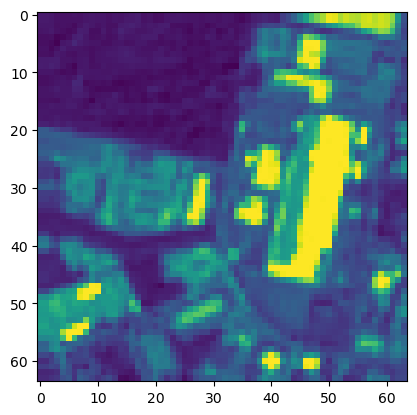

In [6]:
# plaatje weergeven
plt.imshow(industrial.permute(1, 2, 0));

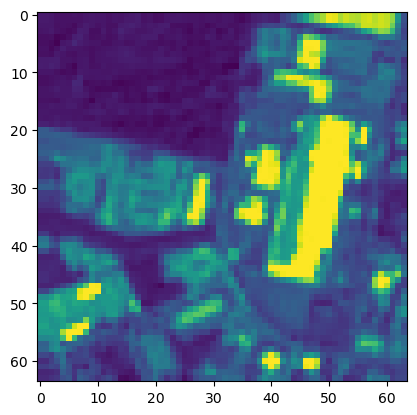

In [7]:
# plaatje weergeven op alternatieve manier. Hetzelfde beeld?
plt.imshow(torch.einsum('cwh->whc', industrial));

### Opdracht 2: convolutie + padding uitvoeren

<p>
De basis-ingrediënten van een CNN, convolutie en pooling, hebben we al met de hand uitgevoerd tijdens het practicum Numpy 2.
Ditmaal voeren we een convolutie filter uit met <a href="https://pytorch.org/docs/stable/nn.functional.html">PyTorch Functional</a>
</p>

<p>
Maak een <a href="https://en.wikipedia.org/wiki/Kernel_(image_processing)">3 x 3 kernel</a> om een edge te detecteren en representeer de kernel als een Pytorch Tensor met naam <u>edgeFilter</u>
    <note>HINT: Hieronder is als voorbeeld de <i>eenheidsmatrix</i> gedefinieerd</note>
</p>

In [8]:
edgeFilter = torch.Tensor(
        [
            [1, 0, 0], 
            [0, 1, 0], 
            [0, 0, 1]
        ]
).unsqueeze(0).unsqueeze(0)

In [9]:
# Create Vertical edge filter
edgeFilter = torch.Tensor(
        [
            [1, 0, -1], 
            [1, 0, -1], 
            [1, 0, -1]
        ]
).unsqueeze(0).unsqueeze(0)

In [10]:
# met 2,0,-2 maak je er een Sobel kernel van
edgeFilter = torch.Tensor(
        [
            [1, 0, -1], 
            [2, 0, -2], 
            [1, 0, -1]
        ]
).unsqueeze(0).unsqueeze(0)

<p>
    Maak o.b.v. <u>edgeFilter</u> een Conv2d filter met als
    <ul>
        <li>stride 1 (default) geeft aan hoeveel de kernel verplaatst per stap</li>
        <li>padding 0 (default) geeft aan hoe we omgaan met de randen</li>
        <li>naam <u>edgeConv</u></li>
    </ul>
    <note>HINT: Zie <a href="https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html">Pytorch documentatie</a></note>
</p>            

In [11]:
edgeFilter.requires_grad = True

In [12]:
# Oplossing
# Using torch.nn.Conv2d to apply the filter later
# edgeConv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0) 

edgeConv = torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=0) 

# torch.nn heeft Conv2d met hoofdletter en torch.nn.functional heeft conv2d met een kleine letter!

In [13]:
with torch.no_grad():
    edgeConv.weight = nn.Parameter(edgeFilter)
    
# je voegt de kernel toe aan je convolutiefilter

<p>Pas je ontworpen filter toe op 'Industrial_1.jpg'</p>

In [14]:
# Apply the filter
industrialFiltered = edgeConv(industrial)
forestFiltered = edgeConv(forest)

<p>
    Geef filteredImage weer <u>met plt.imshow</u><br>
    Maak daarbij gebruik van de <a href="https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html#numpy.squeeze">Numpy functie squeeze</a> en de <a href="https://pytorch.org/docs/stable/generated/torch.Tensor.detach_.html">Pytorch.Tensor methode</a>
</p>

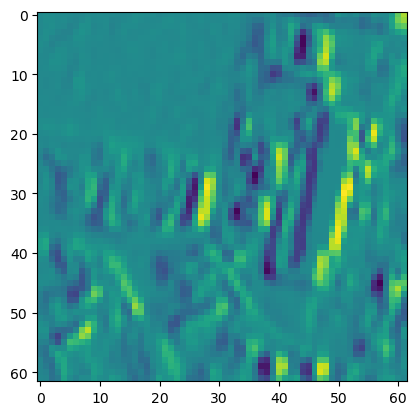

In [15]:
# Oplossing
# Use squeeze and detach to plot image

industrialFiltered = torch.Tensor.detach(industrialFiltered)
plt.imshow(np.squeeze(industrialFiltered))

# merk op dat de breedte van het plaatje 62 pixels is en niet 64 pixels 

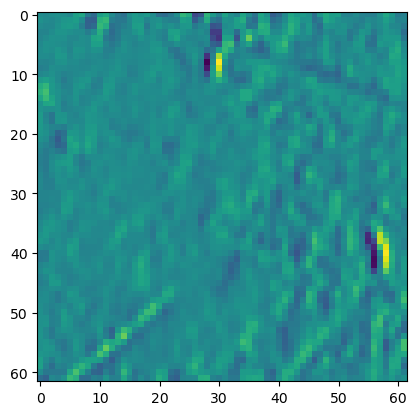

In [16]:
forestFiltered = torch.Tensor.detach(forestFiltered)
plt.imshow(np.squeeze(forestFiltered))

**Herhaal bovenstaande stappen voor een Forest Image uit de EuroSAT Dataset**

### Reflectie

Zijn 'Industrial_1.jpg' en 'Forrest_1.jpg' na een convolutie beter te onderscheiden?

**Extra: varieer de stride en de padding en toon de resultaten**

### Bronnen

[EuroSAT project](https://github.com/phelber/eurosat)

[Pytorch Neural Nets](https://pytorch.org/docs/stable/nn.html)

[Kernels](https://en.wikipedia.org/wiki/Kernel_(image_processing))

[A simple CNN with Pytorch](https://tomroth.com.au/pytorch-cnn)

[A guide to convolution arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf)

[Using Dropout Regularization in PyTorch Models](https://machinelearningmastery.com/using-dropout-regularization-in-pytorch-models)